In [50]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    f1_score, accuracy_score, confusion_matrix, roc_curve
)

from joblib import load
from creditcard_ml.core.feature_engineering import build_features


In [51]:
df = pd.read_csv(DATA_PATH)
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,scaled_amount,scaled_time,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.244964,-1.996583,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,-0.342475,-1.996583,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,1.160686,-1.996562,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.140534,-1.996562,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,-0.073403,-1.996541,0


In [57]:
metrics_old = {}

if os.path.exists(METRICS_PATH):
    with open(METRICS_PATH) as f:
        metrics_old = json.load(f)

metrics_old


{'auc': 0.9562670295326909,
 'precision': 0.948051948051948,
 'recall': 0.7448979591836735,
 'f1': 0.8342857142857143}

In [64]:
SCALER_AMOUNT_PATH = "../src/creditcard_ml/model/scaler_amount.pkl"
SCALER_TIME_PATH   = "../src/creditcard_ml/model/scaler_time.pkl"
MODEL_PATH         = "../src/creditcard_ml/model/model.pkl"

DATA_PATH          = "../data/processed.csv"
METRICS_PATH       = "../metrics.json"

In [65]:
import os;

print("Scaler Amount:", os.path.exists(SCALER_AMOUNT_PATH));
print("Scaler Time:", os.path.exists(SCALER_TIME_PATH));
print("Model:", os.path.exists(MODEL_PATH));
print("Data:", os.path.exists(DATA_PATH));
print("Metrics:", os.path.exists(METRICS_PATH));


Scaler Amount: True
Scaler Time: True
Model: True
Data: True
Metrics: True


In [68]:
# Separa X e y
X = df.drop(columns=["Class"])
y = df["Class"]

# Aplica feature engineering
X_transformed = build_features(X.copy(), is_train=False)

# Carrega modelo
model = load(MODEL_PATH)

# Previsões
y_pred = model.predict(X_transformed)
y_prob = model.predict_proba(X_transformed)[:, 1]

# Métricas recalculadas
metrics_new = {
    "global": {
        "auc": roc_auc_score(y, y_prob),
        "precision": precision_score(y, y_pred),
        "recall": recall_score(y, y_pred),
        "f1": f1_score(y, y_pred),
        "accuracy": accuracy_score(y, y_pred),
        "confusion_matrix": confusion_matrix(y, y_pred).tolist()
    },
    "features": list(X_transformed.columns),
    "n_features": X_transformed.shape[1],
}

# Salvar metrics.json atualizado
with open(METRICS_PATH, "w") as f:
    json.dump(metrics_new, f, indent=4)

metrics_new


FileNotFoundError: [Errno 2] No such file or directory: 'src/creditcard_ml/model/scaler_amount.pkl'

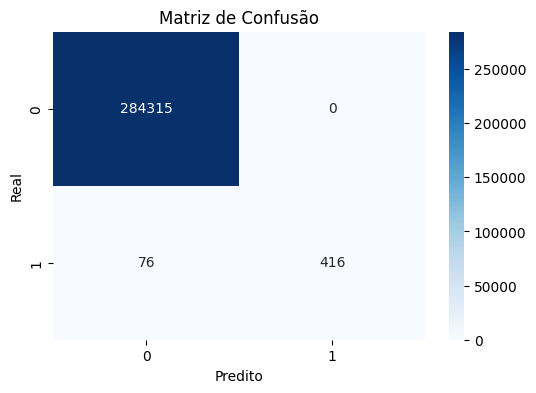

In [30]:
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


In [31]:
fpr, tpr, thresholds = roc_curve(y, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {metrics_new['global']['auc']:.4f}")
plt.plot([0,1], [0,1], "--")
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title("Curva ROC")
plt.legend()
plt.show()


NameError: name 'metrics_new' is not defined

<Figure size 600x400 with 0 Axes>

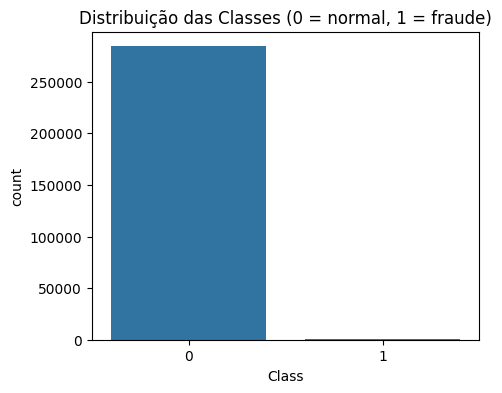

In [32]:
plt.figure(figsize=(5,4))
sns.countplot(x=df["Class"])
plt.title("Distribuição das Classes (0 = normal, 1 = fraude)")
plt.show()


In [33]:
importances = model.feature_importances_
features = X_transformed.columns

imp_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=imp_df.head(20), x="importance", y="feature")
plt.title("Top 20 Features Mais Importantes")
plt.show()

imp_df


NameError: name 'X_transformed' is not defined

In [34]:
print("=== RESUMO DO MODELO ===")
print(f"AUC:       {metrics_new['global']['auc']:.6f}")
print(f"Precision: {metrics_new['global']['precision']:.6f}")
print(f"Recall:    {metrics_new['global']['recall']:.6f}")
print(f"F1 Score:  {metrics_new['global']['f1']:.6f}")
print(f"Accuracy:  {metrics_new['global']['accuracy']:.6f}")

print("\nArquivo metrics.json atualizado com sucesso! 🚀")


=== RESUMO DO MODELO ===


NameError: name 'metrics_new' is not defined